In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

train_path = 'train_new.csv'
train_data = pd.read_csv(train_path)

In [2]:
from autosklearn.regression import AutoSklearnRegressor

In [3]:
print(train_data.head())

                ID District      Block  CultLand  CropCultLand  \
0  ID_GTFAC7PEVWQ9  Nalanda  Noorsarai        45            40   
1  ID_TK40ARLSPOKS  Nalanda     Rajgir        26            26   
2  ID_1FJY2CRIMLZZ     Gaya      Gurua        10            10   
3  ID_I3IPXS4DB7NE     Gaya      Gurua        15            15   
4  ID_4T8YQWXWHB4A  Nalanda  Noorsarai        60            60   

                               LandPreparationMethod CropTillageDate  \
0               TractorPlough FourWheelTracRotavator      2022-07-20   
1  WetTillagePuddling TractorPlough FourWheelTrac...      2022-07-18   
2               TractorPlough FourWheelTracRotavator      2022-06-30   
3               TractorPlough FourWheelTracRotavator      2022-06-16   
4                   TractorPlough WetTillagePuddling      2022-07-19   

   CropTillageDepth         CropEstMethod RcNursEstDate  ... Harv_method  \
0                 5  Manual_PuddledRandom    2022-06-27  ...     machine   
1                 

A very simple preprocessing method to test if AutoML tools are able to figure out the best model with a non-optimal preprocessing.

In [4]:
# Convert datetime columns to datetime format and extract year, month, day, try to use this simple preprocessing method first
datetime_cols = ['CropTillageDate', 'RcNursEstDate', 'Harv_date', 'Threshing_date']
for col in datetime_cols:
    train_data[col] = pd.to_datetime(train_data[col])
    train_data[col + '_year'] = train_data[col].dt.year
    train_data[col + '_month'] = train_data[col].dt.month
    train_data[col + '_day'] = train_data[col].dt.day

# Drop original datetime columns, only use new columns
train_data.drop(columns=datetime_cols, inplace=True)

# Encode categorical columns
categorical_cols = train_data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le


# Preparing the data for modeling
# Training Features
X = train_data.drop(['ID', 'Yield'], axis=1) 
# Target Feature
y = train_data['Yield']  

# Splitting the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fit AutoML pipeline on the train datasets.

In [5]:
automl = AutoSklearnRegressor(time_left_for_this_task=3600, per_run_time_limit=360, n_jobs=-1, memory_limit=None)
automl.fit(X_train, y_train)

AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                     memory_limit=None, n_jobs=-1, per_run_time_limit=360)

Predict on the test dataset.

In [6]:
y_pred = automl.predict(X_test)
# get the Score of the model
# Calculate R2 score as a simple performance metric
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

r2

show_modes_str=automl.show_models()
print(show_modes_str)

{72: {'model_id': 72, 'rank': 1, 'cost': 0.08095480120730092, 'ensemble_weight': 0.16000000000000003, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f15da14cc10>, 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f155cb2b910>, 'regressor': <autosklearn.pipeline.components.regression.RegressorChoice object at 0x7f155cb2b160>, 'sklearn_regressor': HistGradientBoostingRegressor(l2_regularization=0.0031095164511457042,
                              learning_rate=0.0456113860575098, max_iter=512,
                              max_leaf_nodes=4, min_samples_leaf=4,
                              n_iter_no_change=1, random_state=1,
                              validation_fraction=0.24294893242634646,
                              warm_start=True)}, 163: {'model_id': 163, 'rank': 2, 'cost': 0.09474572964521488, 'ensemble_weight': 0.24000000000000002, 'data_preprocess

Show statistical analysis results.

In [7]:
sprint_statistics_str = automl.sprint_statistics()
print(sprint_statistics_str)

auto-sklearn results:
  Dataset name: 4fd5909c-dbeb-11ee-b7d7-955f16c1bb91
  Metric: r2
  Best validation score: 0.919045
  Number of target algorithm runs: 1100
  Number of successful target algorithm runs: 959
  Number of crashed target algorithm runs: 87
  Number of target algorithms that exceeded the time limit: 53
  Number of target algorithms that exceeded the memory limit: 1



Check the model leaderboard

In [8]:
automl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
72,1,0.16,gradient_boosting,0.080955,32.248499
732,2,0.04,libsvm_svr,0.086825,2.015737
297,3,0.04,gradient_boosting,0.088216,1.694268
247,4,0.10,mlp,0.091412,2.109581
642,5,0.02,gradient_boosting,0.091909,3.608867
245,6,0.12,gradient_boosting,0.094329,1.289953
163,7,0.24,libsvm_svr,0.094746,3.587713
652,8,0.14,gradient_boosting,0.094900,3.913848
252,9,0.10,gradient_boosting,0.099091,1.106634


However, the mean_sqaured_error still shows a huge gap with the normal methods without AutoML

In [10]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

119.21914224098232


Check the permutation importance of the model parameters

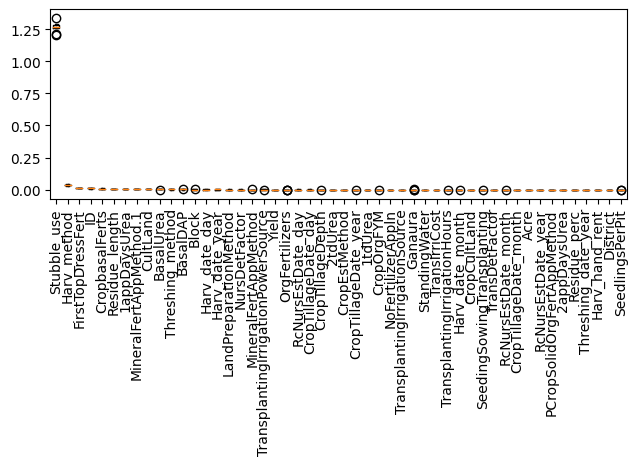

SeedlingsPerPit: -0.001 +/- 0.001
District  : -0.001 +/- 0.000
Harv_hand_rent: -0.001 +/- 0.001
Threshing_date_year: -0.000 +/- 0.000
Residue_perc: -0.000 +/- 0.000
2appDaysUrea: -0.000 +/- 0.000
PCropSolidOrgFertAppMethod: -0.000 +/- 0.000
RcNursEstDate_year: -0.000 +/- 0.000
Acre      : 0.000 +/- 0.000
CropTillageDate_month: 0.000 +/- 0.000
RcNursEstDate_month: 0.000 +/- 0.000
TransDetFactor: 0.000 +/- 0.000
SeedingSowingTransplanting: 0.000 +/- 0.000
CropCultLand: 0.000 +/- 0.000
Harv_date_month: 0.000 +/- 0.000
TransplantingIrrigationHours: 0.000 +/- 0.000
TransIrriCost: 0.000 +/- 0.000
StandingWater: 0.000 +/- 0.000
Ganaura   : 0.000 +/- 0.001
TransplantingIrrigationSource: 0.000 +/- 0.000
NoFertilizerAppln: 0.000 +/- 0.000
CropOrgFYM: 0.000 +/- 0.000
1tdUrea   : 0.000 +/- 0.000
CropTillageDate_year: 0.000 +/- 0.000
CropEstMethod: 0.000 +/- 0.000
2tdUrea   : 0.000 +/- 0.000
CropTillageDepth: 0.000 +/- 0.000
CropTillageDate_day: 0.001 +/- 0.001
RcNursEstDate_day: 0.001 +/- 0.001
Or

In [13]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
r = permutation_importance(automl, X_test, y_test, n_repeats=10, random_state=0)

sort_idx = r.importances_mean.argsort()[::-1]

plt.boxplot(
    r.importances[sort_idx].T, labels=[train_data.columns[i] for i in sort_idx]
)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

for i in sort_idx[::-1]:
    print(
        f"{train_data.columns[i]:10s}: {r.importances_mean[i]:.3f} +/- "
        f"{r.importances_std[i]:.3f}"
    )

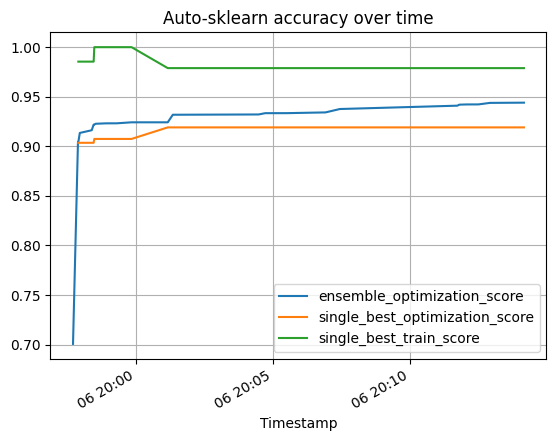

In [16]:
poT = automl.performance_over_time_
poT.plot(
    x="Timestamp",
    kind="line",
    legend=True,
    title="Auto-sklearn accuracy over time",
    grid=True,
)
plt.show()